# **Custom YOLO detector using [Real-time YOLOv4 Object Detection on Webcam in Google Colab | Images and Video](https://https://www.youtube.com/watch?v=ebAykr9YZ30&t=634s&ab_channel=TheAIGuy) as reference.**

<br />The implementation was done as follows:

<br />**1.** Import dependencies; clone and build open source neural network framework darknet's repository on github; and download the scaled yolov4 weights file.

In [1]:
#Import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# clone darknet repo
!pwd
!git clone https://github.com/AlexeyAB/darknet

/content
Cloning into 'darknet'...
remote: Enumerating objects: 15424, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 15424 (delta 0), reused 0 (delta 0), pack-reused 15423
Receiving objects: 100% (15424/15424), 14.05 MiB | 8.36 MiB/s, done.
Resolving deltas: 100% (10364/10364), done.


In [3]:
# As per Darknet's documentation, change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i'' -e 's/OPENCV=0/OPENCV=1/g' Makefile # set opencv to 1 (on)
!sed -i 's/GPU=0/GPU=1/' Makefile # set GPU to 1 (on)
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile # set CUDNN to 1 (on)
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile # set CUDNN_HALF to 1 (on)
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile # set LIBSO to 1 (on)

/content/darknet


In [4]:
!make #builds darknet

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [5]:
# download the scaled yolov4 weights file provided by AlexeyAB (creator of yolo v3) that is pre-trained to detect 80 classes (objects), 
# set as yolov4 weights and then remove the file
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq" -O yolov4-csp.weights && rm -rf /tmp/cookies.txt

--2022-06-13 21:24:46--  https://docs.google.com/uc?export=download&confirm=t&id=1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq
Resolving docs.google.com (docs.google.com)... 172.217.194.101, 172.217.194.100, 172.217.194.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9lbf8kiai6085s96tiiesqvfi08fvq45/1655155425000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download [following]
--2022-06-13 21:24:47--  https://doc-14-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9lbf8kiai6085s96tiiesqvfi08fvq45/1655155425000/17800843676226924807/*/1V3vsIaxAlGWvK4Aar9bAiK5U0QFttKwq?e=download
Resolving doc-14-84-docs.googleusercontent.com (doc-14-84-docs.googleusercontent.com)... 142.251.12.132, 2404:6800:4003:c11::84
Connecting to doc-14-84-docs.googleusercontent.com (doc-1

**2.** Load model description and weights from configuration files and define width and height of images based on that.

**3.1.** Create a function to get image ratios to convert bounding boxes to the image's proper size ("get_image_ratios"): 

**3.2.** Create a function to encapsulates the objected detection in a picture ("detect_objects_in_picture")
1.   Apply modifications do the images so it fits darknet demands
2.   Resize the image based on the model description's size
3.   Return a list with highest confidence class and their bounding boxes



In [6]:
# import darknet functions to perform object detections
from darknet import *

# load model description and weights from config files
network, class_names, class_colors = load_network("cfg/yolov4-csp.cfg", "cfg/coco.data", "yolov4-csp.weights")
width = network_width(network) # set provided width, in case of the chosen model, 608
height = network_height(network) # set provided height, in case of the chosen model, 608

def get_image_ratios(img, width, height):
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height
  return width_ratio, height_ratio

def detect_objects_in_picture(img, width, height):
  # As darknet doesn't accept numpy images.
  # Create one with image we reuse for each detect
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converts the image from RGB to BGR color space
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR) # Resize the image provided using the model's size

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes()) # Copy data from a contiguous byte array into image.
  detections = detect_image(network, class_names, darknet_image) # Returns a list with highest confidence class and their bounding boxes
  free_image(darknet_image) # Free the provided image in order to avoid memory leak
  return detections

**4.** Detect the object of a given image (that comes withing the darknet data folder)

**5.** With the resulting list of defined classes and their bounding boxes, show them on top of the given image.

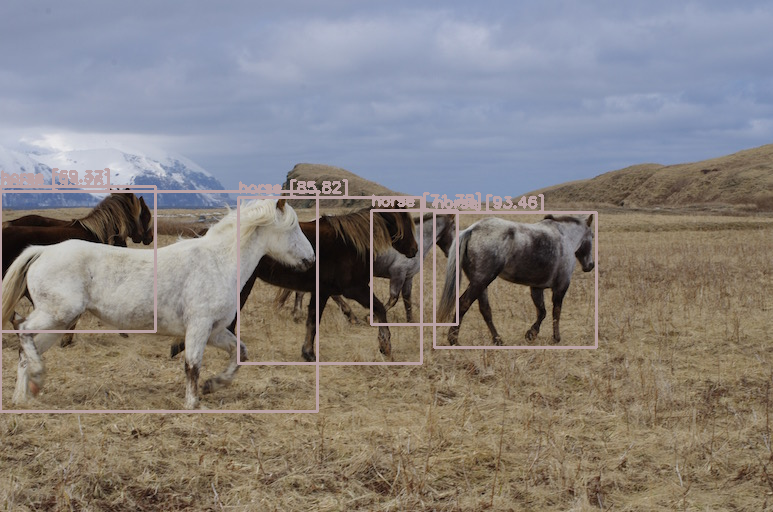

In [7]:
# Run test on horses.jpg image that comes within the data folder
image = cv2.imread("data/horses.jpg") # Read the image
width_ratio, height_ratio = get_image_ratios(image, width, height) # Load the image and size into the previous custom function "get_image_ratios"
detections = detect_objects_in_picture(image, width, height) # Load the image and size into the previous custom function "detect_objects_in_picture"

for label, confidence, bbox in detections: # Loop through the list with highest confidence class and their bounding boxes
  left, top, right, bottom = bbox2points(bbox) # From bounding box yolo format to corner points cv2 rectangle
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio) # Apply the previous calculated ratio so the bounding box is show correctly on the provided image
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2) # Draw the bounding box on the image
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),
                    (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    class_colors[label], 2) # Write the label corresponding to the bouding box on the image
cv2_imshow(image) # Show the image

##**YOLOv4 applied to a picture taken by webcam**

**4.** Another helper fuction "js_to_image" needs to be created. As we know, pictures taken by webcam using Javascript will result into an image encoded with base64 format. However, it cannot be used as input to the yolo detector, so it's necessary to convert it to an OpenCV BGR image.

In [13]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

**5.** Lastly, it's necessary to create the html layout that will be used to display the webcam image to the user, accompanied by a button, so that he/she can capture a picture. Likewise, a canvas element is also necessary to drawn the taken picture by the user into a file. This is done by the take_photo function.

In [18]:
def take_photo(filename='yolo_photo.jpg', quality= 1.0):
  js = Javascript('''
    async function takePhoto(quality) {
      // Create button element
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Take foto';
      div.appendChild(capture);

      // Create video element that will display the webcam
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      // Append the elements in the document tree
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream; // Define the video source as the user stream (webcam)
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      // From video stream, "draw" the captured picture using canvas
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js) # Show code

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call darknet helpers on webcam image
  width_ratio, height_ratio = get_image_ratios(img, width, height) # Load the image and size into the previous custom function "get_image_ratios"
  detections = detect_objects_in_picture(img, width, height) # Load the image and size into the previous custom function "detect_objects_in_picture"

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to yolo_photo.jpg


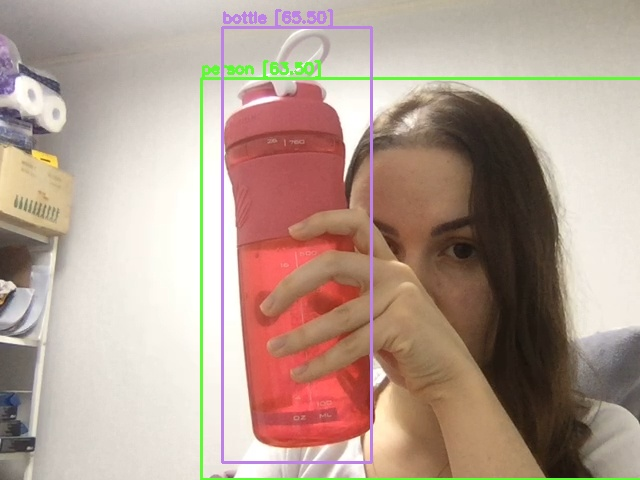

In [25]:
try:
  filename = take_photo('yolo_photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

##**YOLOv4 applied to webcam video**

**6.** In case of detecting objects while showing the webcam image, it's necessary to create a function "video_stream" that will be responsable for generating the DOM elements (status, video, button and etc), capture and display the video stream.

**7.** Also, as YOLOv4 doesn't accept video as input, it's necessary to create a function "video_frame" to capture frames (that will be used as input of the darknet algorithm) of the video stream.

In [21]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    // Create the elements within the html document
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      // Create element that will root the video element
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      // Create status element
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      // Video element
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      // Element that will display image
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      // Create finish button
      const instruction = document.createElement('button');
      instruction.textContent = 
          'When finished, click here or on the video to stop this demo';
      instruction.style.color = 'white'
      instruction.style.backgroundColor = 'red'
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
      
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

**8.** In the same way as defined in "js_to_image" function, the resulting bounding box image (numpy array) by the yolo detector cannot be saved as picture on the local directory to further be shows to the user, so a function ("bbox_to_bytes") to transform it into an array of bytes is necessary.

In [22]:
# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

**10.** Finally, using the previous created functions, inside a infinite loop (that will be broken when the user clicks the "finish" button):

1.   Captures frame from video
2.   Convert frame base64 image to byte array
3.   Create an overlay for bounding boxes that will be displayed on the n + 1 frame
3.   Detect the object of a given image (that comes withing the darknet data folder)
4.   With the resulting list of defined classes and their bounding boxes, show them on top of the next frame



In [23]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our helper functions on video frame
    width_ratio, height_ratio = get_image_ratios(frame, width, height) # Load the image and size into the previous custom function "get_image_ratios"
    detections = detect_objects_in_picture(frame, width, height) # Load the image and size into the previous custom function "detect_objects_in_picture"

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>